# Demo - Siren

In [62]:
import os
import sys

from pyprojroot import here

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# spyder up to find the root
root = here(project_files=[".root"])
exp = here(
    relative_project_path=root.joinpath("experiments/expv2"), project_files=[".local"]
)


# append to path
sys.path.append(str(root))
sys.path.append(str(exp))

In [2]:
import imageio
import numpy as np
import pytorch_lightning as pl
import torch
import wandb
from inr4ssh._src.data.ssh_obs import (
    load_ssh_altimetry_data_test,
    load_ssh_altimetry_data_train,
    load_ssh_correction,
)
from inr4ssh._src.datamodules.ssh_obs import SSHAltimetry
from inr4ssh._src.features.data_struct import df_2_xr
from inr4ssh._src.interp import interp_on_alongtrack
from inr4ssh._src.metrics.psd import compute_psd_scores, select_track_segments
from inr4ssh._src.metrics.stats import (
    calculate_nrmse,
    calculate_nrmse_elementwise,
    calculate_rmse_elementwise,
)
from inr4ssh._src.models.activations import get_activation
from inr4ssh._src.models.siren import ModulatedSirenNet, Modulator, Siren, SirenNet
from inr4ssh._src.postprocess.ssh_obs import postprocess
from inr4ssh._src.preprocess.coords import (
    correct_coordinate_labels,
    correct_longitude_domain,
)
from inr4ssh._src.preprocess.subset import spatial_subset, temporal_subset
from inr4ssh._src.viz.psd import plot_psd_score, plot_psd_spectrum
from loguru import logger
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, LRScheduler, WandbLogger
from skorch.dataset import ValidSplit
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.notebook import tqdm as tqdm

pl.seed_everything(123)

import matplotlib.pyplot as plt
import seaborn as sns
from inr4ssh._src.viz.movie import create_movie

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Global seed set to 123


In [3]:
import argparse

import config

In [4]:
# initialize argparse
parser = argparse.ArgumentParser()

# add all experiment arguments
parser = config.add_logging_args(parser)
parser = config.add_data_dir_args(parser)
parser = config.add_data_preprocess_args(parser)
parser = config.add_feature_transform_args(parser)
parser = config.add_train_split_args(parser)
parser = config.add_dataloader_args(parser)
parser = config.add_model_args(parser)
parser = config.add_loss_args(parser)
parser = config.add_optimizer_args(parser)
parser = config.add_eval_data_args(parser)
parser = config.add_eval_metrics_args(parser)
parser = config.add_viz_data_args(parser)

# parse args
args = parser.parse_args([])

# modify args (PERSONAL)
args.train_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/train"
args.ref_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/ref"
args.test_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/test"

# # modify args (MEOMCAL1)
# args.train_data_dir = "/home/johnsonj/data/dc_2021/raw/train"
# args.ref_data_dir = "/home/johnsonj/data/dc_2021/raw/ref"
# args.test_data_dir = "/home/johnsonj/data/dc_2021/raw/test"
#
args.time_min = "2017-01-01"
args.time_max = "2017-02-01"
args.eval_time_min = "2017-01-01"
args.eval_time_max = "2017-02-01"
args.eval_dtime = "12_h"

# logger args
args.wandb_resume = True
args.wandb_mode = "disabled"
args.wandb_project = "inr4ssh"
args.wandb_entity = "ige"
args.wandb_log_dir = "/Users/eman/code_projects/logs"
args.wandb_id = None

In [5]:
wandb_run = wandb.init(
    config=args,
    mode=args.wandb_mode,
    project=args.wandb_project,
    entity=args.wandb_entity,
    dir=args.wandb_log_dir,
    resume=args.wandb_resume,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


to extract a default argument if it is in the name space
`lr = getattr(args, "lr", 1e-4)`

In [6]:
logger.info("Initializing data module...")
dm = SSHAltimetry(args)

In [7]:
dm.setup()

2022-07-06 10:48:15.253 | INFO     | inr4ssh._src.datamodules.ssh_obs:setup:24 - Getting training data...
2022-07-06 10:48:15.253 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:58 - loading data...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 90.31it/s]
2022-07-06 10:48:15.498 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:61 - subsetting data...
2022-07-06 10:48:15.524 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:64 - getting feature scaler...
2022-07-06 10:48:15.524 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:67 - feature scaling...
2022-07-06 10:48:15.582 | INFO     | inr4ssh._src.datamodules.ssh_obs:setup:28 - Train/Va

In [8]:
dl_train = dm.train_dataloader()
dl_valid = dm.val_dataloader()
dl_predict = dm.predict_dataloader()

In [9]:
len(dm.ds_train), len(dm.ds_valid), len(dm.ds_predict)

(255185, 28354, 167076)

## Skorch Training

In [10]:
X_train, y_train = dm.ds_train[:]
X_valid, y_valid = dm.ds_valid[:]
(X_test,) = dm.ds_predict[:]
X_train = torch.cat([X_train, X_valid])
y_train = torch.cat([y_train, y_valid])

In [11]:
X_train.shape, X_test.shape

(torch.Size([283539, 4]), torch.Size([167076, 4]))

In [12]:
logger.info("Creating neural network...")
dim_in = X_train.shape[1]
dim_hidden = args.hidden_dim
dim_out = y_train.shape[1]
num_layers = args.n_hidden
w0 = args.siren_w0
w0_initial = args.siren_w0_initial
c = args.siren_c
final_activation = get_activation(args.final_activation)

In [13]:
siren_net = SirenNet(
    dim_in=dim_in,
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    num_layers=num_layers,
    w0=w0,
    w0_initial=w0_initial,
    final_activation=final_activation,
)

In [14]:
# if torch.has_mps:
#     device = "mps"
# elif torch.has_cuda:
#     device = "cuda"
# else:
#     device = "cpu"
device = "mps"

In [15]:
args.num_epochs = 500
args.learning_rate = 1e-3

In [16]:
# learning rate scheduler
lr_scheduler = LRScheduler(
    policy="ReduceLROnPlateau",
    monitor="valid_loss",
    mode="min",
    factor=0.1,
    patience=10,
)
# learning rate scheduler

# lr_scheduler = LRScheduler(
#     policy=CosineAnnealingLR,
#     T_max=args.num_epochs
# )

# early stopping
estop_callback = EarlyStopping(
    monitor="valid_loss",
    patience=50,
)

wandb_callback = WandbLogger(wandb_run, save_model=True)

callbacks = [
    ("earlystopping", estop_callback),
    ("lrscheduler", lr_scheduler),
    ("wandb_logger", wandb_callback),
]

In [17]:
# train split percentage
train_split = ValidSplit(0.1, stratified=False)

In [18]:
skorch_net = NeuralNetRegressor(
    module=siren_net,
    max_epochs=args.num_epochs,
    lr=args.learning_rate,
    batch_size=args.batch_size,
    device=device,
    optimizer=torch.optim.Adam,
    train_split=train_split,
    callbacks=callbacks,
)

In [19]:
skorch_net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9359        0.0186  4.3141
      2        0.0161        0.0158  4.4356
      3        0.0149        0.0149  4.0709
      4        0.0144        0.0148  3.8812
      5        0.0140        0.0146  3.7104
      6        0.0138        0.0157  3.7077
      7        0.0139        0.0144  3.7633
      8        0.0138        0.0145  3.7403
      9        0.0138        0.0141  3.6911
     10        0.0138        0.0155  3.7701
     11        0.0136        0.0146  3.8288
     12        0.0135        0.0155  3.7505
     13        0.0133        0.0143  3.8396
     14        0.0131        0.0155  3.7832
     15        0.0128        0.0134  3.7820
     16        0.0127        0.0154  3.7673
     17        0.0123        0.0126  3.7131
     18        0.0123        0.0154  3.7139
     19        0.0119        0.0123  3.7325
     20        0.0120        0.0148  4.0619
     21        0.0116        0.0

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SirenNet(
    (layers): ModuleList(
      (0): Siren(
        (activation): Sine()
      )
      (1): Siren(
        (activation): Sine()
      )
      (2): Siren(
        (activation): Sine()
      )
      (3): Siren(
        (activation): Sine()
      )
      (4): Siren(
        (activation): Sine()
      )
      (5): Siren(
        (activation): Sine()
      )
    )
    (last_layer): Siren(
      (activation): Identity()
    )
  ),
)

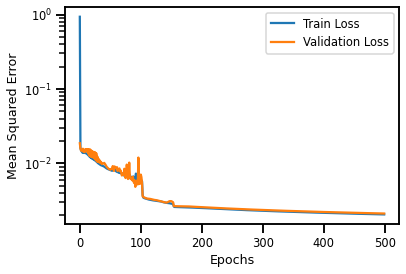

In [20]:
fig, ax = plt.subplots()

ax.plot(skorch_net.history[:, "train_loss"], label="Train Loss")
ax.plot(skorch_net.history[:, "valid_loss"], label="Validation Loss")

ax.set(yscale="log", xlabel="Epochs", ylabel="Mean Squared Error")

plt.legend()
plt.show()

## Predictions

### SSH Along Track

In [21]:
%%time

# open along track dataset
ds_alongtrack = load_ssh_altimetry_data_test(args.test_data_dir)

# correct labels
ds_alongtrack = correct_coordinate_labels(ds_alongtrack)

# correct longitude domain
ds_alongtrack = correct_longitude_domain(ds_alongtrack)

# temporal subset
ds_alongtrack = temporal_subset(
    ds_alongtrack,
    time_min=np.datetime64(args.time_min),
    time_max=np.datetime64(args.time_max),
    time_buffer=args.time_buffer,
)

# spatial subset
ds_alongtrack = spatial_subset(
    ds_alongtrack,
    lon_min=args.eval_lon_min,
    lon_max=args.eval_lon_max,
    lon_buffer=args.eval_lon_buffer,
    lat_min=args.eval_lat_min,
    lat_max=args.eval_lat_max,
    lat_buffer=args.eval_lat_buffer,
)

# convert to dataframe
ds_alongtrack = ds_alongtrack.to_dataframe().reset_index().dropna()

# convert to df using the transform
X_test = dm.scaler.transform(ds_alongtrack)
y_test = ds_alongtrack["sla_unfiltered"]

CPU times: user 1.45 s, sys: 109 ms, total: 1.56 s
Wall time: 1.6 s


In [22]:
%%time
import time

t0 = time.time()
predictions = skorch_net.predict(torch.Tensor(X_test))
t1 = time.time() - t0

wandb_run.log(
    {
        "time_predict_alongtrack": t1,
    }
)

CPU times: user 123 ms, sys: 18.2 ms, total: 141 ms
Wall time: 183 ms


#### Stats

In [23]:
rmse_mean, rmse_std = calculate_rmse_elementwise(y_test, predictions)

wandb_run.log(
    {
        f"rmse_mean_alongtrack": rmse_mean,
        f"rmse_std_alongtrack": rmse_std,
    }
)

In [24]:
print(f"RMSE: {rmse_mean}\nRMSE (stddev): {rmse_std}")

RMSE: 0.04646690562367439
RMSE (stddev): 0.04398259520530701


In [25]:
metrics = ["custom", "std", "mean", "minmax", "iqr"]

for imetric in metrics:

    nrmse_mean, nrmse_std = calculate_nrmse_elementwise(y_test, predictions, imetric)

    print(f"RMSE ({imetric}): mean - {nrmse_mean:.4f}, stddev - {nrmse_std:.4f}")

    wandb_run.log(
        {
            f"nrmse_mean_alongtrack_{imetric}": nrmse_mean,
            f"nrmse_std_alongtrack_{imetric}": nrmse_std,
        }
    )

RMSE (custom): mean - 0.7756, stddev - 0.2124
RMSE (std): mean - 0.7536, stddev - 0.2332
RMSE (mean): mean - 0.4572, stddev - 0.5137
RMSE (minmax): mean - 0.9744, stddev - 0.0242
RMSE (iqr): mean - 0.7218, stddev - 0.2634


#### PSD Score

In [26]:
psd_metrics = compute_psd_scores(
    ssh_true=y_test.squeeze(),
    ssh_pred=predictions.squeeze(),
    delta_x=args.eval_psd_velocity * args.eval_psd_delta_t,
    npt=None,
    scaling="density",
    noverlap=0,
)

In [27]:
print(psd_metrics)

Resolved Scale: 148.880 (km)


In [28]:
wandb_run.log(
    {
        "resolved_scale_alongtrack": psd_metrics.resolved_scale,
    }
)

#### Viz - PSD Score

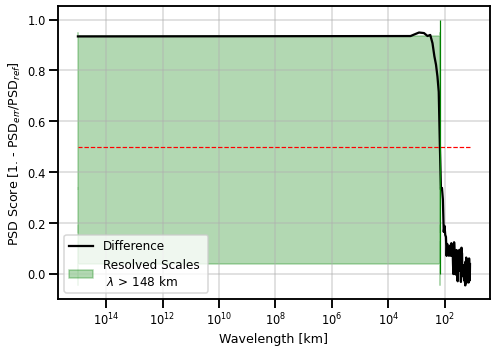

In [29]:
fig, ax = plot_psd_score(
    psd_diff=psd_metrics.psd_diff,
    psd_ref=psd_metrics.psd_ref,
    wavenumber=psd_metrics.wavenumber,
    resolved_scale=psd_metrics.resolved_scale,
)

wandb_run.log(
    {
        "psd_score_alongtrack": wandb.Image(fig),
    }
)

#### Viz - PSD Spectrum

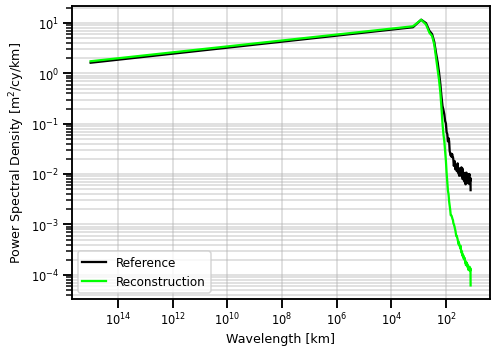

In [30]:
fig, ax = plot_psd_spectrum(
    psd_study=psd_metrics.psd_study,
    psd_ref=psd_metrics.psd_ref,
    wavenumber=psd_metrics.wavenumber,
)

wandb_run.log(
    {
        "psd_spectrum_alongtrack": wandb.Image(fig),
    }
)

### SSH Grid

In [31]:
%%time
# extract grid variables
(X_test,) = dm.ds_predict[:]

# TESTING
logger.info("Making predictions...")
t0 = time.time()
predictions = skorch_net.predict(torch.FloatTensor(X_test))
t1 = time.time() - t0

2022-07-06 11:21:37.478 | INFO     | __main__:<module>:5 - Making predictions...


CPU times: user 926 ms, sys: 68.9 ms, total: 995 ms
Wall time: 1.4 s


In [32]:
# convert to da
logger.info("Convert data to xarray ds...")
ds_oi = dm.X_pred_index
ds_oi["ssh"] = predictions
ds_oi = df_2_xr(ds_oi)

2022-07-06 11:21:38.914 | INFO     | __main__:<cell line: 2>:2 - Convert data to xarray ds...


In [33]:
# open correction dataset
logger.info("Loading SSH corrections...")
ds_correct = load_ssh_correction(args.ref_data_dir)

2022-07-06 11:21:38.965 | INFO     | __main__:<cell line: 2>:2 - Loading SSH corrections...


In [34]:
# correct predictions
logger.info("Correcting SSH predictions...")
ds_oi = postprocess(ds_oi, ds_correct)

2022-07-06 11:21:39.127 | INFO     | __main__:<cell line: 2>:2 - Correcting SSH predictions...


In [35]:
# open along track dataset
logger.info("Loading test dataset...")
ds_alongtrack = load_ssh_altimetry_data_test(args.test_data_dir)

# interpolate along track
logger.info("Interpolating alongtrack obs...")
alongtracks = interp_on_alongtrack(
    gridded_dataset=ds_oi,
    ds_alongtrack=ds_alongtrack,
    lon_min=args.eval_lon_min,
    lon_max=args.eval_lon_max,
    lat_min=args.eval_lat_min,
    lat_max=args.eval_lat_max,
    time_min=args.eval_time_min,
    time_max=args.eval_time_max,
)

2022-07-06 11:21:39.162 | INFO     | __main__:<cell line: 2>:2 - Loading test dataset...
2022-07-06 11:21:39.185 | INFO     | __main__:<cell line: 6>:6 - Interpolating alongtrack obs...


#### Stats

In [36]:
# RMSE
logger.info("Getting RMSE Metrics...")


rmse_metrics = calculate_nrmse(
    true=alongtracks.ssh_alongtrack,
    pred=alongtracks.ssh_map,
    time_vector=alongtracks.time,
    dt_freq=args.eval_bin_time_step,
    min_obs=args.eval_min_obs,
)

print(rmse_metrics)
wandb_run.log(
    {
        "rmse_mean_grid": rmse_metrics.rmse_mean,
        "rmse_std_grid": rmse_metrics.rmse_std,
        "nrmse_mean_grid": rmse_metrics.nrmse_mean,
        "nrmse_std_grid": rmse_metrics.nrmse_std,
    }
)

2022-07-06 11:21:39.277 | INFO     | __main__:<cell line: 2>:2 - Getting RMSE Metrics...


RMSE (Mean): 0.071
RMSE (Std): 0.019
NRMSE (Mean): 0.862
NRMSE (Std): 0.069


#### PSD

In [37]:
logger.info("Selecting track segments...")
tracks = select_track_segments(
    time_alongtrack=alongtracks.time,
    lat_alongtrack=alongtracks.lat,
    lon_alongtrack=alongtracks.lon,
    ssh_alongtrack=alongtracks.ssh_alongtrack,
    ssh_map_interp=alongtracks.ssh_map,
)

delta_x = args.eval_psd_velocity * args.eval_psd_delta_t

2022-07-06 11:21:39.526 | INFO     | __main__:<cell line: 1>:1 - Selecting track segments...


In [38]:
# compute scores
logger.info("Computing PSD Scores...")
psd_metrics = compute_psd_scores(
    ssh_true=tracks.ssh_alongtrack,
    ssh_pred=tracks.ssh_map,
    delta_x=delta_x,
    npt=tracks.npt,
    scaling="density",
    noverlap=0,
)

2022-07-06 11:21:39.559 | INFO     | __main__:<cell line: 2>:2 - Computing PSD Scores...


In [39]:
print(psd_metrics)

Resolved Scale: 134.759 (km)


In [40]:
wandb_run.log(
    {
        "resolved_scale_grid": psd_metrics.resolved_scale,
    }
)

#### Viz - PSD Spectraum

2022-07-06 11:21:39.662 | INFO     | __main__:<cell line: 1>:1 - Plotting PSD Score...


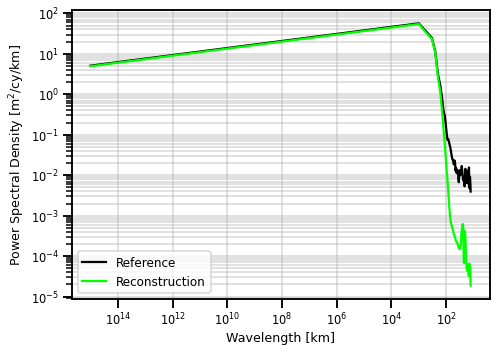

In [41]:
logger.info("Plotting PSD Score...")
fig, ax = plot_psd_spectrum(
    psd_study=psd_metrics.psd_study,
    psd_ref=psd_metrics.psd_ref,
    wavenumber=psd_metrics.wavenumber,
)

wandb_run.log(
    {
        "psd_spectrum_grid": wandb.Image(fig),
    }
)

#### Viz - PSD Score

2022-07-06 11:21:40.113 | INFO     | __main__:<cell line: 1>:1 - Plotting PSD Score...


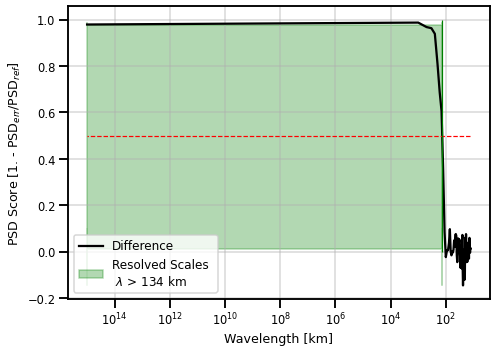

2022-07-06 11:21:40.312 | INFO     | __main__:<cell line: 15>:15 - Finished Script...!


In [42]:
logger.info("Plotting PSD Score...")
fig, ax = plot_psd_score(
    psd_diff=psd_metrics.psd_diff,
    psd_ref=psd_metrics.psd_ref,
    wavenumber=psd_metrics.wavenumber,
    resolved_scale=psd_metrics.resolved_scale,
)

wandb_run.log(
    {
        "psd_score_grid": wandb.Image(fig),
    }
)

logger.info("Finished Script...!")

## Visualization

#### SSH Field

In [43]:
# import hvplot.xarray

In [44]:
# ds_oi.ssh.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True,
#     width=500, height=400, cmap="viridis")

In [45]:
save_path = wandb.run.dir

In [46]:
create_movie(ds_oi.ssh, f"pred", "time", cmap="viridis", file_path=save_path)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

Movie created at movie_pred.mp4
GIF created at movie_pred.gif


#### Gradient (Norm)

In [47]:
from inr4ssh._src.operators.finite_diff import calculate_gradient, calculate_laplacian

ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")

In [48]:
create_movie(
    ds_oi.ssh_grad, f"pred_grad", "time", cmap="Spectral_r", file_path=save_path
)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

Movie created at movie_pred_grad.mp4
GIF created at movie_pred_grad.gif


In [49]:
# ds_oi.ssh_grad.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True,
#     width=500, height=400, cmap="Spectral_r")

#### Laplacian (Norm)

In [50]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")

In [51]:
# ds_oi.ssh_lap.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True,
#     width=500, height=400, cmap="RdBu_r")

In [52]:
create_movie(ds_oi.ssh_lap, f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

Movie created at movie_pred_lap.mp4
GIF created at movie_pred_lap.gif


In [53]:
# def custom_plotfunc(ds, fig, tt, *args, **kwargs):

#     # find indices
#     indx = np.where(
#         (np.abs(ds_test_obs_summer.time.values - ds.time.values[tt]) <= dt)
#     )[0]

#     # subset data
#     lat = ds_test_obs_summer.latitude.values[indx]
#     lon = ds_test_obs_summer.longitude.values[indx]
#     data = ds_test_obs_summer.sla_unfiltered.values[indx]

#     vmin = ds_test_obs_summer.sla_unfiltered.min()
#     vmax = ds_test_obs_summer.sla_unfiltered.max()

#     # do scatter plot
#     ax = fig.add_subplot(111, aspect="equal")

#     pts = ax.scatter(
#         lon,
#         lat,
#         c=data,
#         cmap="RdBu_r",
#         vmin=ds_test_obs_summer.sla_unfiltered.min(),
#         vmax=ds_test_obs_summer.sla_unfiltered.max(),
#     )
#     ax.set_title("")
#     ax.set_facecolor("0.5")
#     ax.set_aspect(0.75)
#     ax.set(
#         xlim=[ds.longitude.values.min() - 0.5, ds.longitude.values.max() + 0.5],
#         ylim=[
#             ds.latitude.values.min() - 0.5,
#             ds.latitude.values.max() + 0.5,
#         ],
#     )
#     plt.colorbar(pts)
#     # plt.tight_layout()

#     return None, None

In [54]:
# mov_custom = Movie(ds_summer.sla, custom_plotfunc)

In [55]:
# mov_custom.preview(9)

In [56]:
# mov_custom.save(
#     "plots/movie_ssh_gulf_jja_test.gif",
#     remove_movie=True,
#     progress=True,
#     framerate=5,
#     gif_framerate=5,
#     overwrite_existing=True,
# )

In [57]:
# def make_customplotfunc(ds_obs):
#     def f(ds, fig, tt, *args, **kwargs):

#         # find indices
#         indx = np.where((np.abs(ds_obs.time.values - ds.time.values[tt]) <= dt))[0]

#         # subset data
#         lat = ds_obs.latitude.values[indx]
#         lon = ds_obs.longitude.values[indx]
#         data = ds_obs.sla_unfiltered.values[indx]

#         vmin = ds_obs.sla_unfiltered.min()
#         vmax = ds_obs.sla_unfiltered.max()

#         # do scatter plot
#         ax = fig.add_subplot(111, aspect="equal")

#         pts = ax.scatter(
#             lon,
#             lat,
#             c=data,
#             cmap="RdBu_r",
#             vmin=ds_obs.sla_unfiltered.min(),
#             vmax=ds_obs.sla_unfiltered.max(),
#         )
#         ax.set_title(f"{ds.time.values[tt]:.10}")
#         ax.set_facecolor("0.5")
#         ax.set_aspect(0.75)
#         ax.set(
#             xlim=[ds.longitude.values.min() - 0.5, ds.longitude.values.max() + 0.5],
#             ylim=[
#                 ds.latitude.values.min() - 0.5,
#                 ds.latitude.values.max() + 0.5,
#             ],
#             xlabel="Longitudes [degrees_east]",
#             ylabel="Latitudes [degrees_north]",
#         )
#         plt.colorbar(pts)
#         plt.tight_layout()

#         return None, None

#     return f

In [58]:
# f_cust = make_customplotfunc(ds_test_obs_winter)

# mov_custom = Movie(ds_winter.sla, f_cust)

In [59]:
# mov_custom.save(
#     "plots/movie_ssh_gulf_djf_test.gif",
#     remove_movie=True,
#     progress=True,
#     framerate=5,
#     gif_framerate=5,
#     overwrite_existing=True,
# )